Analyse area, 
plot analysis result of elg etc.
Input: "-thre.tif", "-area.csv", "-elg.cv2.csv"
Output: "\ana-plot"

Data structure: "colony_index/colony_index-c.tif", -BG.tif, -thre.tif, -BG_Simple Segmentation.tiff

1. data plot. Input: -thre.tif
   * white pixels => cell area => colony growth rate
   * Colony density = cell area/ conlony contour area
   * Last frame => t_c
   * Contour area on the last frame => A_c
2. Real time area growth rate
3. 

In [1]:
# import the essential packages 
import numpy as np   # for numerics
import glob   #for parsing directories and files
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  #for plotting
import random
import cv2
from PIL import Image
import os
from matplotlib import cm
import json
import pickle
import pandas as pd

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
# rplcpath ='ForPub/300-LBLMagar/00772-2'
# head, rplcIdx = os.path.split(rplcpath)

scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2


In [7]:
"""
Analyze the colony-level data (revised 250314, DataFrame)
assuming 1 colony of interest per frame

find contour
0-level contour: colony contour area
cell area (1)0-level contour - all holes (2)all white pixels if no other spots
density = cell area / colony area
circularity = (4*np.pi*area) / (peri)**2  

---input---
-thre.tif
----output---
-area.csv
["frame", "area_mask", "area_colony", "area_cells", "density", "circularity"] (in frames and pixel^2)

---Note---
no plot generated, later read in txt, and fit fIdx - area_cellsto get colony_growth_rate
"""

exppath = 'ForPub/075-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00738']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 

    threName = rplcIdx + '-thre.tif'
    areaName = rplcIdx + '-area-xy.csv' # area of colony and colony contour
    fpath = os.path.join(rplcpath, threName)
    areapath = os.path.join(rplcpath, areaName)
    
    img_segs = []
    ret,img_segs = cv2.imreadmulti(mats=img_segs, 
                               filename=fpath, flags=cv2.IMREAD_GRAYSCALE)
    height, width = img_segs[0].shape
#     print(rplcIdx, len(img_segs), height, width)
    cntx_min, cntx_max = width*0.2, width*0.8
    cnty_min, cnty_max = height*0.2, height*0.8
#     print(cntx_min, cntx_max, cnty_min, cnty_max)
    
    area_list = [] 
    for i in range(len(img_segs)):
        img_seg = img_segs[i]
        area_mask = np.sum(img_seg)/255  # all white pixels
        ### check
#         if i <= 10:
#             print(i, area_mask)
        contours, hierarchy = cv2.findContours(img_seg, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        area_cells = 0  # Area of 0-level contour (including holes)
        area_colony = 0  # Area of the contour without holes
        for j,cnt in enumerate(contours):
            area = cv2.contourArea(cnt)   
            cnt0 = 0
            if hierarchy[0][j][3] == -1 and area >300:  # top-level contour
                out_peri = cv2.arcLength(cnt, True)
                out_area = cv2.contourArea(cnt)
                M = cv2.moments(cnt)
                cntx = M['m10']/M['m00']   
                cnty = M['m01']/M['m00']
#                 print(i, j, cntx, cnty, area)
                if cntx_min <= cntx <= cntx_max and cnty_min <= cnty <= cnty_max:
                    area_cells += area
                    area_colony += area
                    cnt0 += 1
                    if cnt0 >1:
                        print('Multiple cnt0!')
            elif hierarchy[0][j][3] != -1:  # Child contour (hole)
                area_cells -= area

        density = area_cells / area_colony
        circularity = (4*np.pi*out_area) / (out_peri)**2
        area_list.append([i, cntx, cnty, area_mask, area_cells, area_colony, density, circularity])

    columns = ["frame", "x", "y", "area_mask", "area_colony", "area_cells", "density", "circularity"]
    df= pd.DataFrame(area_list, columns=columns)
    df.to_csv(areapath, index=False)

In [6]:
#####test
print(df.tail())

     frame           x           y  area_mask  area_colony  area_cells  \
116    116  477.325506  636.081354   349795.0     342324.5    377233.5   
117    117  477.915881  635.724298   366322.0     358558.0    395866.0   
118    118  477.661974  636.173165   383304.0     375318.0    413613.5   
119    119  477.516316  635.330931   401530.0     393333.0    432815.0   
120    120  477.390664  635.790348   421067.0     412703.0    453253.5   

      density  circularity  
116  0.907460     0.278016  
117  0.905756     0.307265  
118  0.907412     0.313359  
119  0.908779     0.318193  
120  0.910535     0.310965  


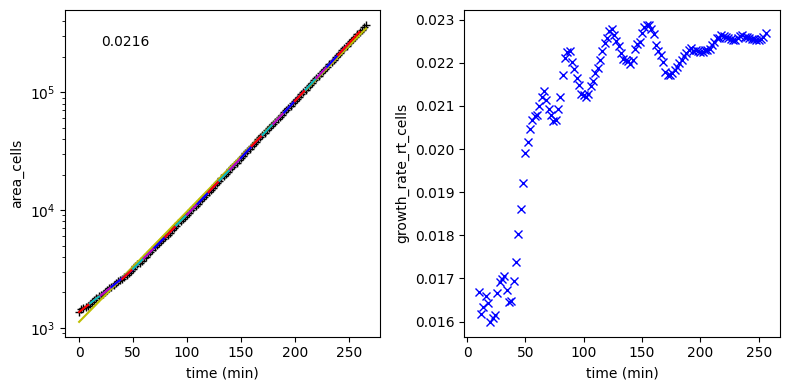

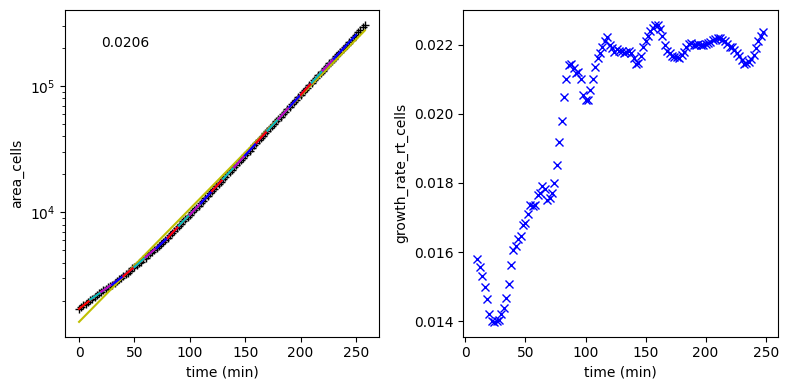

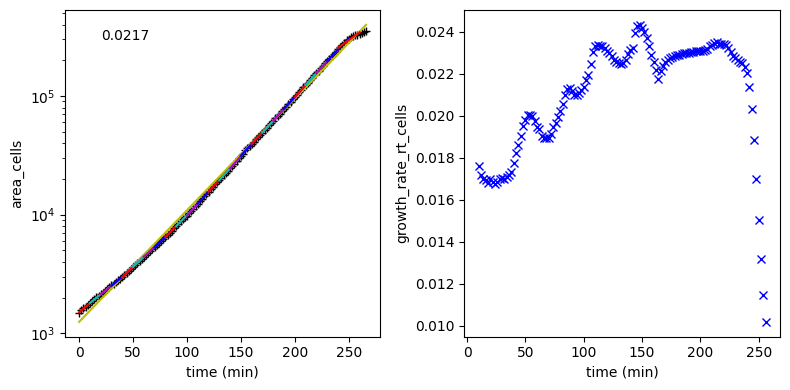

In [33]:
"""
colony real-time growth rate
fit exponential "fIdx - area_cell" [-fit_window, +fit_window]

---input---
rplcIdx + '-area.csv'
"frame", "area_mask", "area_colony", "area_cells", "density", "circularity"

----output---
"-area-rt.csv"
plotcheck "area_fit_check.png"

"""
import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

exppath = 'ForPub/300-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00738']

fit_window = 5 # [-5, 5]
col_name = "area_cells"
out_name = "growth_rate_rt_cells"
ms = ['b-', 'r-', 'c-', 'm-']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 

    areaName = rplcIdx + '-area.csv' # area of colony and colony contour
    areapath = os.path.join(rplcpath, areaName)
    plotpath = rplcpath + '/ana-plot/'
    if not os.path.exists(plotpath):
        os.makedirs(plotpath)
    plotName = rplcIdx + out_name + '.png'
    
    area_df = pd.read_csv(areapath, header=0)
    # Initialize the new column in tracks DataFrame
    area_df[out_name] = None 
    fig, ax = plt.subplots(1,2, figsize=[8,4])
    
    growthRate_data = []
    time_array = area_df["frame"].to_numpy() *minpf  # 2 min per frame
    time_reset = time_array - time_array[0]
    area_array = area_df[col_name].to_numpy() # * scale100 * scale100 not necessary unless for plot
    ax[0].plot(time_array, area_array, "k+")
    
    # fit overall
    (x0_p, k_p), pcov = curve_fit(ef_e, time_reset, np.log(area_array), p0=[1,0.02]) 
    area_fit = ef(time_reset, np.exp(x0_p), k_p) 
    ax[0].semilogy(time_array, area_fit, "y-")
    ax[0].set_xlabel("time (min)")
    ax[0].set_ylabel(col_name)
    ax[0].text(time_array[10], area_array[-10], f"{k_p:.4f}", color="k")
    
    for j in range(time_array.shape[0] - 2*fit_window):
        center_index = j+fit_window
        time_array_rt = time_array[j: j+2*fit_window+1]
        time_reset_rt = time_array_rt - time_array[j]
        area_array_rt = area_array[j: j+2*fit_window+1]
        # fit [-5, 5]
        (x0_rt, k_rt), pcov = curve_fit(ef_e, time_reset_rt, np.log(area_array_rt), p0=[1,0.02]) 
        
        #check fitting every 5 frames
        if center_index%5 == 0:
#             print (center_index)
            area_rt_fit = ef(time_reset_rt, np.exp(x0_rt), k_rt) 
            ax[0].plot(time_array_rt, area_rt_fit, ms[int(center_index/5)%4])        
        
        area_df.at[center_index , out_name] = k_rt
        
    # update -area.csv
    area_df.to_csv(areapath, index=False)
    
    # plot growth rate realtime to time
    area_df_clean = area_df.dropna()
    ax[1].plot(area_df_clean["frame"]*minpf, area_df_clean[out_name], "bx")
    ax[1].set_xlabel("time (min)")
    ax[1].set_ylabel(out_name)
    plt.tight_layout()
#     plt.show()
    plt.savefig(os.path.join(plotpath, plotName), dpi=300)

In [7]:
"""
read in rplcIdx + '-area.txt'
'# frame,area_colony,area_cells,density,circularity
fit exponential "fIdx - area_cell" with frame 10 to 70
----output---
colony_growth_rate from fitting

---Note---
no plot generated, growth rate printed
linear fit on log(area)
"""
import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

# exppath = 'data/202312-substrate/ForPub/glass-LB/240229-LB-ana/'  
# exppath = 'data/202312-substrate/ForPub/glass-LBLMagar-075/250117-075-T2-ana/'  
# exppath = 'data/202312-substrate/ForPub/glass-LBLMagar-150/250108-150-ana/'  
# exppath = 'data/202312-substrate/ForPub/glass-LBLMagar-300/250102-3-ana/'  
# exppath = 'data/202312-substrate/ForPub/glass-LBLMagar-600/250115-6-T2-ana/'  

rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['data/202312-substrate/ForPub/glass-LB/240216-LB-T1-ana/00288-1']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 
    areaName = rplcIdx + '-area.txt' # area of colony and colony contour
    areapath = os.path.join(rplcpath, areaName)
    areaData = np.loadtxt(areapath) # fIdx, area_cells, area_colony, density
    time = areaData[10:-10, 0] *minpf 
    area_cell = areaData[10:-10, 1]  # in pixel, not a problem for fitting
    time0 = time-time[0]
    popt, pcov = curve_fit(ef_e, time0, np.log(area_cell), p0=[1,0.02])   # linear fit on log
    x0_p, k_p = popt
    print(rplcIdx, k_p)

00324 0.022345466491533725
00778 0.020676462536255418
00785 0.02210813615921362
00788 0.021763331498551423


154.0
190.0


C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\2798398501.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()
C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\2798398501.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()


210.0
238.0


C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\2798398501.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()
C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\2798398501.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()


212.0
240.0


C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\2798398501.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()
C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\2798398501.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()


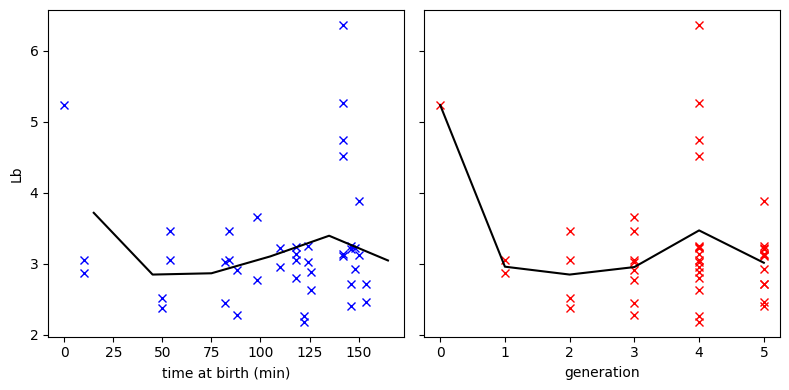

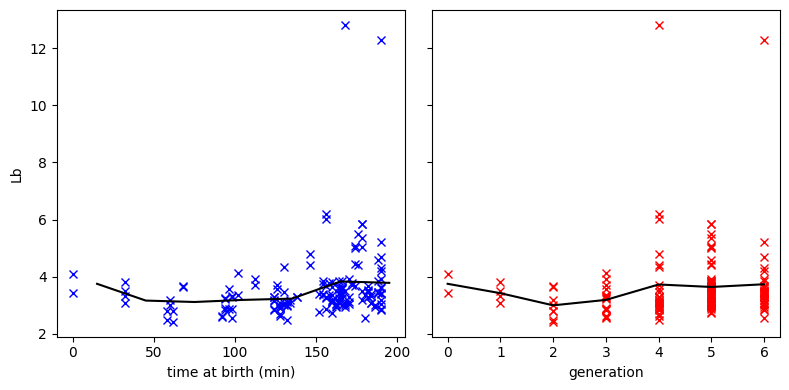

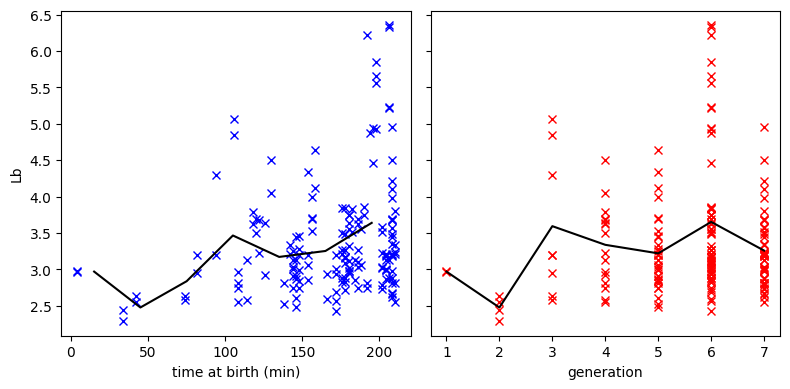

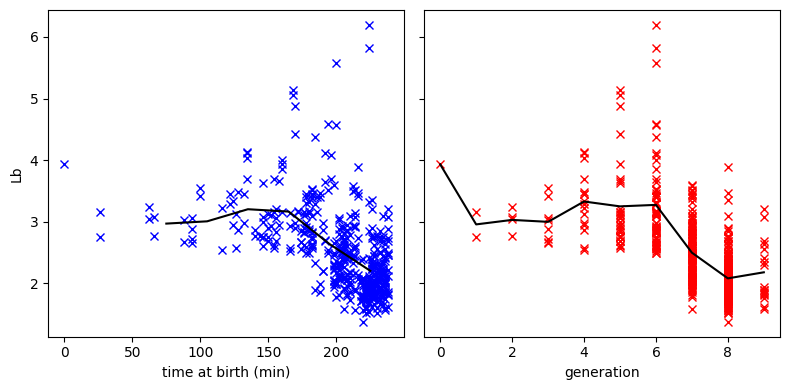

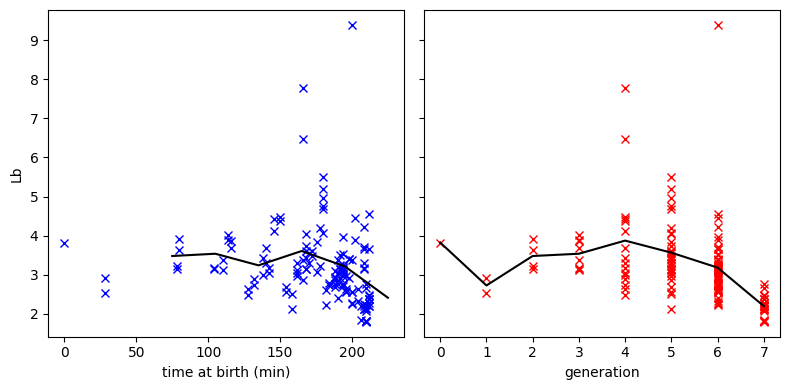

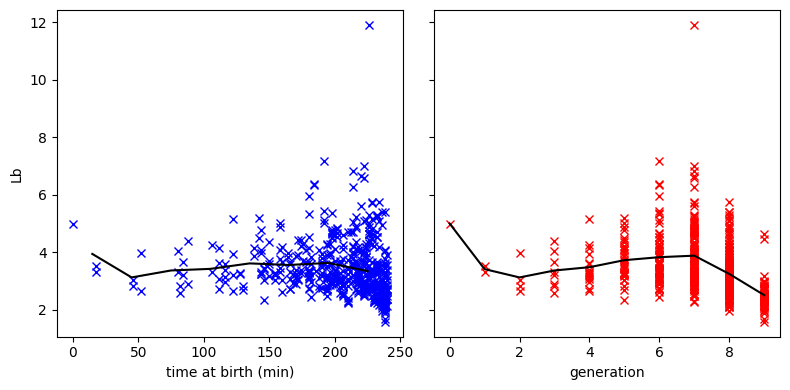

In [69]:
"""
plot elgRate (or division_time, L_b) to generation and time_start
Both scattered data and mean from binning

---input---
-elg-cv2.csv
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]

---output---

"""

# exppath = 'ForPub/075-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00738']


col_name = "Lb"  # division_time

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 

    elgName = rplcIdx + '-elg-cv2.csv' # area of colony and colony contour
    elgpath = os.path.join(rplcpath, elgName)
    plotpath = rplcpath + '/ana-plot/'
    if not os.path.exists(plotpath):
        os.makedirs(plotpath)
    plotName = rplcIdx + col_name+'.png'
    
    fig, ax = plt.subplots(1,2, figsize=[8,4], sharey=True)
    ax[0].set_ylabel(col_name)
#     ax[0].set_ylim(0.005, 0.035)  # only for elgRate
    
    elg_df = pd.read_csv(elgpath, header=0, usecols=["time_start", "generation", col_name])
    elg_df_clean = elg_df.dropna()
    
    # plot to time
    ax[0].set_xlabel("time at birth (min)")
    ax[0].plot(elg_df_clean["time_start"], elg_df_clean[col_name], "bx")
    # bin with 30min and average
    t_max = elg_df_clean["time_start"].max()
    print(t_max) # for check
#     n_bins = t_max // 30 +1
    bins = np.arange(0, t_max+30, 30)
    elg_df_clean["time_bin"] = pd.cut(elg_df_clean["time_start"], bins=bins, right=False)
    elg_df_Tgrouped = elg_df_clean.groupby("time_bin")[col_name].mean().reset_index()
    ax[0].plot(bins[:-1]+15, elg_df_Tgrouped[col_name], "k-")
    
    # plot to generation
    ax[1].set_xlabel("generation")    
    ax[1].plot(elg_df_clean["generation"], elg_df_clean[col_name], "rx")
    elf_df_Ggrouped = elg_df_clean.groupby("generation")[col_name].mean().reset_index()
    ax[1].plot(elf_df_Ggrouped["generation"], elf_df_Ggrouped[col_name], "k-")

    plt.tight_layout()
#     plt.show()
    plt.savefig(os.path.join(plotpath, plotName), dpi=300)

00753 6 [58, 59, 60, 61, 62]


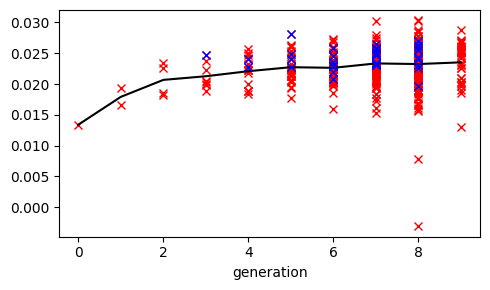

In [12]:
"""
Moved to new notebook "lineage-sort.ipynb"
plot MEAN elgRate (or division_time, L_b) SORTED by lineage until (last generation-3)
Check if there is differentiation

---input---
-elg-cv2.csv
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
-tracks0cv2.csv read in cell_id and lineage

---output---
ana-plot/-sort_lineage.png
v1: pure plot
v2: link lineage
v3: write cell_ID

"""
import ast

exppath = 'ForPub/300-LBLMagar/'
# rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
rplcpathList =['ForPub/300-LBLMagar/00753']

# Function to find all offsprings following cell_ID and lineage list.
def find_offspring(df, parent_cells):
    offspring = {cell: [] for cell in parent_cells}    
    for _, row in df.iterrows():
        lineage = row["lineage"]
        # if not isinstance(lineage, list):
        #     continue
        for parent in parent_cells:
            if parent in lineage:
                offspring[parent].append(row["cell_ID"])    
    return offspring


for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 

    elgName = rplcIdx + '-elg-cv2.csv' # area of colony and colony contour
    elgpath = os.path.join(rplcpath, elgName)
    tracksName = rplcIdx + "-tracks-cv2.csv" 
    trackspath = os.path.join(rplcpath, tracksName)
    plotpath = rplcpath + '/ana-plot/'
    # if not os.path.exists(plotpath):
    #     os.makedirs(plotpath)
    # plotName = rplcIdx + col_name+'.png'
    plotName = rplcIdx +'-9-elg.png'

    tracks_df = pd.read_csv(trackspath, header=0, usecols=["cell_ID", "lineage"])
    tracks_df_s = tracks_df.drop_duplicates(subset="cell_ID", keep="first").reset_index(drop=True)
    tracks_df_s["lineage"] = tracks_df_s["lineage"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    elg_df = pd.read_csv(elgpath, header=0)
    max_generation = elg_df["generation"].max() -3
    parent_mid = elg_df[elg_df["generation"]<max_generation]["cell_ID"].tolist()
    print(rplcIdx, max_generation, parent_mid[-5:])

    # build offspring for each parent cell from 2nd to -3 generations
    offspring_dict = find_offspring(tracks_df_s, parent_mid)
    # mean values, can be others
    # mean_values = {}
    # for parent, offspring in offspring_dict.items():
    #     offspring_data = elg_df[elg_df["cell_ID"].isin(offspring)]
    #     if not offspring_data.empty:  
    #         mean_elg = offspring_data["elgRate_b"].mean()  # Note: default skipnan=True
    #         mean_lb = offspring_data["Lb"].mean()
    #         mean_td = offspring_data["division_time"].mean()
    #         mean_values[parent] = {"mean_elg": mean_elg, "mean_lb": mean_lb, "mean_td": mean_td}
    #     else:
    #         mean_values[parent] = {"mean_elg": None, "mean_lb": None, "mean_td": None}

    # test plot with different cell_ID    
    elg_df_clean = elg_df[["generation", "elgRate_b"]].dropna()
    test_ID = 9
    offspring = offspring_dict[test_ID]
    offspring_data = elg_df[elg_df["cell_ID"].isin(offspring)]
    elg_df_sub = offspring_data.dropna()

    fig, ax = plt.subplots(figsize=[5,3])
    # fig, ax = plt.subplots(1,3, figsize=[9,3])
    
    # plot to generation
    ax.set_xlabel("generation")    
    ax.plot(elg_df_clean["generation"], elg_df_clean["elgRate_b"], "rx")
    elf_df_Ggrouped = elg_df_clean.groupby("generation")["elgRate_b"].mean().reset_index()
    ax.plot(elf_df_Ggrouped["generation"], elf_df_Ggrouped["elgRate_b"], "k-")
    ax.plot(elg_df_sub["generation"], elg_df_sub["elgRate_b"], "bx")

    plt.tight_layout()
#     plt.show()
    plt.savefig(os.path.join(plotpath, plotName), dpi=300)

In [17]:
print (offspring_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])


In [65]:
print(elg_df_Tgrouped[col_name])

0    42.000000
1    36.000000
2    38.333333
3    33.000000
4    26.333333
Name: division_time, dtype: float64


In [36]:
import pandas as pd
import numpy as np

# Create DataFrame
df = pd.DataFrame({
    "val1": [0, 1, 2, 2.5, 3, 3.5, 4, 5, 6, 7],
    "val2": [np.nan, 4, 3, 5, 2, 6, 8, 7, 9, np.nan]
})

# Define bin edges (adjust as needed)
bins = [0, 2, 4, 6, 8]  # Defines bin edges (e.g., 0-2, 2-4, 4-6, 6-8)
bin_labels = ["0-2", "2-4", "4-6", "6-8"]  # Labels for bins

# Assign bin labels to val1
df["val1_bin"] = pd.cut(df["val1"], bins=bins, right=False)  # right=False means left-inclusive [)

# Group by bins and calculate mean of val2
df_grouped = df.groupby("val1_bin")["val2"].mean().reset_index()

# Display result
print(df_grouped)


  val1_bin  val2
0   [0, 2)   4.0
1   [2, 4)   4.0
2   [4, 6)   7.5
3   [6, 8)   9.0


C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_28768\3006022478.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("val1_bin")["val2"].mean().reset_index()
